In [1]:
import os
import random

import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
import torchvision.models
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patheffects as pe
import torchvision.transforms as transforms
import yaml
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import LearningRateFinder
from lightning.pytorch import Trainer, LightningModule
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [2]:
# Путь к данным обучения
data_path = "./Emergency Vehicles Russia.v1i.yolov8"

# Выбор устройства для работы модели
if torch.cuda.is_available():
    device="cuda"
else:
    device="cpu"

# Проверка доступности гпу
# print(device)

In [3]:
def seed_everything(seed):
    """
        Фисксация всех сидов в программе для корректного
        сравнения оптимизаторов и обучаемых моделей

        :seed: число для фиксации сидов
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
seed_everything(seed)

In [4]:
def ReadClassDict(path):
    '''
        Загружаем список классов изображений из yaml файла

    :param path:
    :return:
    '''

    with open(path, "r") as f:
        file = yaml.safe_load(f)
        class_list = file["names"]
        class_dict = dict(enumerate(class_list, start=0))

    return class_dict

class_dict = ReadClassDict("./" + data_path + "/data.yaml")

# print(class_dict) # {0: 'ambulance', 1: 'fire fighting vehicle', 2: 'intensive care unit', 3: 'non emergency car', 4: 'police car'}

In [73]:
def collate_fn(batch, downsample=32, model_type="yolo"):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        # get_txt_data -> res = (center_x, center_y, width, height, card_class)
        
        if model_type == "yolo":
            xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
            )
            classes = classes.int()
        
            # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
            w_box = (xmax - xmin)/640 # ширина бокса отнормированная
            h_box = (ymax - ymin)/640 # высота бокса отнормированная
    
            # координаты центра и сдвиги
            cx =  (xmin + xmax)/2
            cy =  (ymin + ymax)/2
    
            cx_idx = (cx // downsample).to(torch.long) # индекс центра на карте признаков размера 20x20. Это будут как раз координаты пикселя, куда мы запишем параметры коробки
            cy_idx = (cy // downsample).to(torch.long) # .to(torch.long)
    
            cx_box = cx - (cx//downsample)*downsample # сдивиги относительно cx_idx
            cy_box = cy - (cy//downsample)*downsample # сдивиги относительно cy_idx
            
        elif model_type == "ssd":
            center_x, center_y, width, height, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
            )
            classes = classes.int()
            # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
            w_box = width/640 # ширина бокса отнормированная
            h_box = height/640 # высота бокса отнормированная
    
            # координаты центра и сдвиги
            cx =  center_x
            cy =  center_y
    
            cx_idx = (cx // downsample).to(torch.long) # индекс центра на карте признаков размера 20x20. Это будут как раз координаты пикселя, куда мы запишем параметры коробки
            cy_idx = (cy // downsample).to(torch.long) # .to(torch.long)
    
            cx_box = cx - (cx//downsample)*downsample # сдивиги относительно cx_idx
            cy_box = cy - (cy//downsample)*downsample # сдивиги относительно cy_idx
            
        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes.int()]
        )

    return {"image": imgs, "target": target}

In [72]:
test_col = collate_fn([train_ds[20]], model_type="ssd")
print(test_col["target"].shape)

[(0.47265625, 0.6559888579387186, 0.7578125, 0.6880222841225627, 4), (0.8625, 0.5041782729805014, 0.2734375, 0.34261838440111414, 3)]
tensor([[0.4727, 0.6560, 0.7578, 0.6880, 4.0000],
        [0.8625, 0.5042, 0.2734, 0.3426, 3.0000]])
torch.Size([1, 6, 20, 20])


In [40]:
def get_txt_data(image_path, class_dict):
    """
        Получение списка данных по всем bbox'ам на изображении

        :image_name: имя файла
        :path: путь (test train valid)
        :class_dict: словарь с расшифровкой классов
        :return:
    """
    # TODO заменить на убирание всех форматов лишних, не только jpg
    if image_path.rfind(".jpg"):
        image_path = image_path.replace(".jpg", "")

    # читаем соответствующий изображению txt
    with open(str(image_path).replace("images", "labels") + ".txt", "r") as f:
        # итерация через bbox'ы объектов в файле и их сохранение в один массив
        bboxes = []
        for line in f:
            data = line.split(sep=" ") # class_id center_x center_y width height
            # print(data)
            center_x = float(data[1])
            center_y = float(data[2])
            width = float(data[3])
            height = float(data[4])
            card_class = int(data[0]) # номер класса

            res = (center_x, center_y, width, height, card_class)
            bboxes.append(res)
        return bboxes


# Проверка работы
# print(get_txt_data("Emergency Vehicles Russia.v1i.yolov8/train/images/0c273b07-_44_PNG.rf.24d358e5a9859dde93cf9823287e0f94.jpg", class_dict))
# print(get_txt_data("./Emergency Vehicles Russia.v1i.yolov8/train/images\-10_PNG.rf.0f13a65f5ba37714e528b76181b3dee8.jpg", class_dict))

[(0.5453125, 0.46111111111111114, 0.521875, 0.6666666666666666, 2)]
[(0.8375, 0.5916666666666667, 0.31875, 0.3194444444444444, 4), (0.1984375, 0.6111111111111112, 0.39375, 0.6305555555555555, 4)]


In [6]:
# Класс датасета для доступа к данным во время обучения
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root=data_path, data_type_path="train", seed=seed):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        # Проверка на корректный путь TODO
        if data_type_path not in ["train", "test", "valid"]:
            data_type_path = "train"
        self.filenames = np.array(glob.glob(root + "/" + data_type_path + "/images/*"))

        # {0: 'ambulance', 1: 'fire fighting vehicle', 2: 'intensive care unit', 3: 'non emergency car', 4: 'police car'}
        self.class_dict = ReadClassDict("./" + data_path + "/data.yaml")
        # {'ambulance': 0, 'fire fighting vehicle': 1, 'intensive care unit': 2, 'non emergency car': 3, 'police car': 4}
        self.class_dict_inverted = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        # Перестановка файлов для рандома, сид зафиксирован
        permutation = np.random.permutation(len(self.filenames))

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        image = np.asarray(Image.open(fname))
        bboxes = get_txt_data(fname, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_txt_data(fname, self.class_dict)

    def __len__(self):
        return len(self.filenames)

In [7]:
# Определение нормализации и аугментаций изображений для обучения
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# train_transform = A.Compose(
#     [
#         A.Resize(512, 512),
#         A.augmentations.transforms.Normalize(mean=mean, std=std),
#         ToTensorV2(),
#     ],
#     bbox_params=dict(format="pascal_voc", min_visibility=0.3),
# )
#
# test_transform = A.Compose(
#     [
#         A.Resize(512, 512),
#         A.augmentations.transforms.Normalize(mean=mean, std=std),
#         ToTensorV2(),
#     ],
#     bbox_params=dict(format="pascal_voc", min_visibility=0.5),
# )
train_transform = A.Compose(
    [
        A.Resize(640, 640),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="yolo", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(640, 640),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
        
    ],
    bbox_params=dict(format="yolo", min_visibility=0.5),
)

# Применение аугментаций и создание датасетов для обучения и тестирования
train_ds = MyDataset(root=data_path, transform=train_transform, data_type_path="train")
test_ds = MyDataset(root=data_path, transform=test_transform, data_type_path="test")
val_ds = MyDataset(root=data_path, transform=test_transform, data_type_path="valid")


# print(train_ds.__getitem__(0)["image"].shape)

In [44]:
print(train_ds.__getitem__(0)["image"].shape)

torch.Size([3, 640, 640])


In [75]:
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=7)
train_dataloader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=0,persistent_workers=False, pin_memory=True)
val_dataloader = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=0, persistent_workers=False, pin_memory=True)
test_dataloader = DataLoader(test_ds, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=0, persistent_workers=False, pin_memory=True)

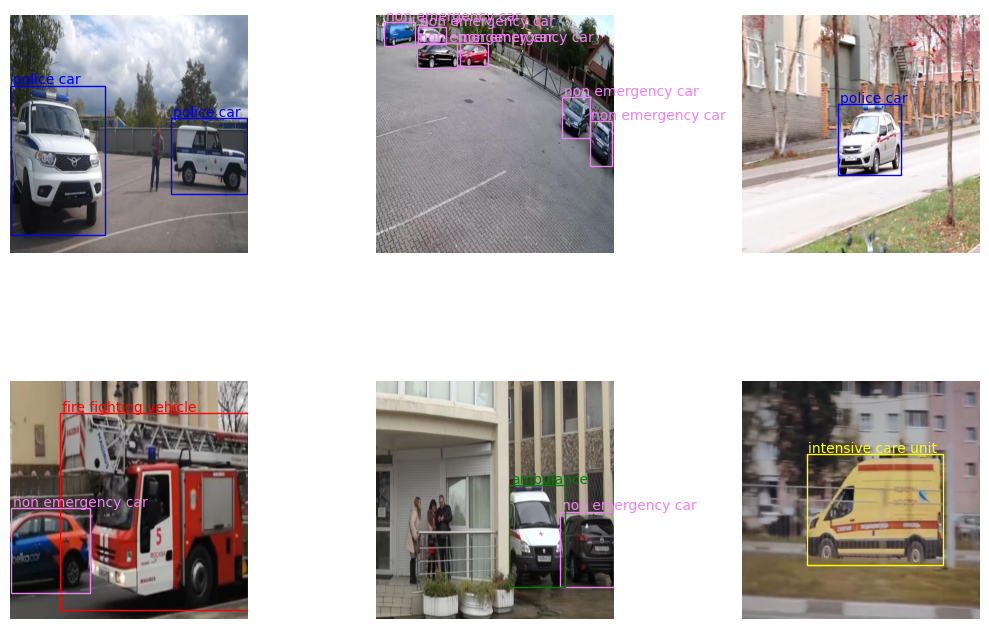

In [16]:
def visualize(images, bboxes, mean, std):
    '''
        Функция для визуализации размеченных данных, изображение и bbox объект

        :param images:
        :param bboxes:
        :param mean:
        :param std:
        :return:
    '''
    
    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)
        if i >= len(images):
            break
        # Смена порядков каналов изображения из torch для отображения в matplotlib
        im = images[i].permute(1, 2, 0)

        # Откат нормализации, обратное преобразование
        im[:,:,0] = im[:,:,0].mul(std[0]) + mean[0]
        im[:,:,1] = im[:,:,1].mul(std[1]) + mean[1]
        im[:,:,2] = im[:,:,2].mul(std[2]) + mean[2]

        # print(im.shape)
        ax.imshow(im, vmin=0, vmax=1)
        # # print("len", len(bboxes))
        for bbox in bboxes[i]:
            
          # print("bbox", bbox)
          # bbox = (center_x center_y width height card_class)
          # {0: 'ambulance', 1: 'fire fighting vehicle', 2: 'intensive care unit', 3: 'non emergency car', 4: 'police car'}
          color_dict = ["green", "red", "yellow", "violet", "blue"]
          
          class_name = bbox[4]
          if type(bbox[4]) != type(int):
              class_color = train_ds.class_dict_inverted[class_name]
          else:
              class_color = train_ds.class_dict[class_name]

          w = bbox[2] * im.shape[1]
          h = bbox[3] * im.shape[0]

          xmin = (bbox[0] * im.shape[1])- w//2
          ymin = (bbox[1] * im.shape[0]) - h//2

          p = plt.Rectangle((xmin, ymin), w, h, fill=False, color=color_dict[class_color])
          ax.add_patch(p)

          ax.text(xmin+5, ymin-5, class_name, size=10, color=color_dict[class_color])

    fig.tight_layout()
    plt.show()

# Визуализация данных
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out], mean, std)

In [14]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    # b - batch size, c - class channels
    b, c = pred.shape
    # print("c", c)
    # print(pred.shape)
    # img_w, img_h = w * upsample, h * upsample

    res =[]

    for image_num in range(b):
      print("im_num", image_num)
      print("im", pred[image_num].shape)

      bboxes = []
      # [0-cx_box, 1-cy_box, 2-w_box, 3-h_box, 4-confidence, 5+-classes]

      # Индексы клеток где confidence >= threshold и есть центр bbox'a
      indices = (pred[image_num][4] > threshold).nonzero()
      print("ind", indices)
      print("ind len", len(indices))

      # Для координат каждой клетки с центром найдем параметры bbox'a
      for center in indices:
          # xmin, ymin, xmax, ymax, confidence, (class/classes) - ssd300_vgg16
        w_box = (pred[image_num][2][center[0]][center[1]].item())*640 # ширина бокса
        h_box = (pred[image_num][3][center[0]][center[1]].item())*640 # высота бокса

        # Сдвиг центра в клетке
        cx_box = pred[image_num][0][center[0]][center[1]].item()
        cy_box = pred[image_num][1][center[0]][center[1]].item()

        # Координаты центра в изображении
        cx = (center[1].item()*upsample + cx_box)
        cy = (center[0].item()*upsample + cy_box)

        xmin = (cx - w_box/2)
        xmax = (cx + w_box/2)
        ymin = (cy - h_box/2)
        ymax = (cy + h_box/2)
        # print("w_box", w_box)
        # print("h_box", h_box)
        # print("cx_box", cx_box)
        # print("cy_box", cy_box)
        # print("cx", cx)
        # print("cy", cy)
        # print("xmin", xmin)
        # print("xmax", xmax)
        # print("ymin", ymin)
        # print("ymax", ymax)

        if c == 6: #target
          card_class = int(pred[image_num][5][center[0]][center[1]].item())
        else: #prediction
          # print(pred)
          # print("size", pred[image_num].shape)
          # print("center", center[0].item(), center[1].item())
          card_class = 0
          # card_class = torch.argmax(pred[image_num][5:][center[0].item()][center[1].item()-5], dim=0)


        bbox = (xmin, ymin, xmax, ymax, card_class)
        # print("bbox", bbox)
        # print(bbox)
        # # Если предсказание - добавляем ббокс только если уверенность больше-равна threshold
        # if c==6 or (c > 6 and pred[image_num][5+card_class] >= threshold):
        bboxes.append(bbox)
      res.append(bboxes)
    print(len(res))
    return res
#
# # Проверка работы кодировщика и декодировщика
test_bboxes = decode_prediction(test_col["target"])
visualize(test_col["image"], test_bboxes)

In [26]:
MyNet.eval()
s = MyNet([train_ds[0]["image"]])
# print(s)
sus = torch.cat((s[0]["boxes"], s[0]["labels"].unsqueeze(1)), 1)
print(sus)
# visualize([train_ds[0]["image"]], sus, mean, std)

tensor([[  0.0000,   0.0000, 640.0001, 640.0001,   1.0000],
        [640.0001, 220.2190, 640.0001, 220.2191,   1.0000],
        [280.6113, 567.1713, 282.5821, 579.5150,   1.0000],
        [640.0001, 312.6498, 640.0001, 312.6512,   1.0000],
        [  0.0000, 452.0443, 640.0001, 532.4935,   1.0000],
        [251.1109, 524.0435, 251.1410, 640.0001,   1.0000],
        [640.0001,  99.6118, 640.0001, 118.9019,   1.0000],
        [640.0001, 252.3084, 640.0001, 252.3310,   1.0000],
        [  0.0000, 224.0606, 640.0001, 255.9223,   1.0000],
        [  0.0000, 439.9879,   0.0000, 640.0001,   1.0000],
        [270.2670, 208.7554, 270.2895, 640.0001,   1.0000],
        [ 80.4372,   0.0000, 118.4849, 640.0001,   1.0000],
        [  0.0000,   0.0000,   0.0000, 640.0001,   1.0000],
        [640.0001,   0.0000, 640.0001,   0.0000,   1.0000],
        [207.9199,   0.0000, 358.7914, 640.0001,   1.0000],
        [  0.0000,   0.0000, 115.2241, 640.0001,   1.0000],
        [101.0790,   0.0000, 101.1899, 6

In [27]:
torch.cat((s[0]["boxes"], s[0]["scores"].unsqueeze(1), s[0]["labels"].unsqueeze(1)), 1)

tensor([[  0.0000,   0.0000, 640.0001, 640.0001,   1.0000,   1.0000],
        [640.0001, 220.2190, 640.0001, 220.2191,   1.0000,   1.0000],
        [280.6113, 567.1713, 282.5821, 579.5150,   1.0000,   1.0000],
        ...,
        [379.3888,   0.0000, 405.6159, 640.0001,   1.0000,   4.0000],
        [  0.0000,   0.0000, 640.0001,   0.0000,   1.0000,   4.0000],
        [216.3141, 197.6161, 445.1451, 197.7770,   1.0000,   4.0000]],
       grad_fn=<CatBackward0>)

In [11]:
import wandb
wandb.login()

wandb: Currently logged in as: miraellax. Use `wandb login --relogin` to force relogin


True

In [18]:
class MyModule(LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model([x])

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.LinearLR(self.optimizer, start_factor=0.01)
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=30, gamma=0.8)
        return {"optimizer": self.optimizer, "lr_scheduler": self.scheduler}

    def training_step(self, train_batch, batch_idx):
        print("train batch", train_batch)
        images, bboxes = train_batch[0], train_batch[1]
        pred = self.model(images)
        loss_dict = model(pred, bboxes)
        print("loss", loss_dict)
        # wandb лог
        # self.log('train_loss ', loss_dict, on_step=False, on_epoch=True)
        # print("Train loss: ", loss)

        # step every x epochs
        if self.trainer.is_last_batch and (self.trainer.current_epoch + 1) % 2 == 0:
          self.scheduler.step()

        # # В конце эпохи сохраняем модель
        # if self.trainer.is_last_batch:
        #     accuracy = evaluate_task(self.model, val_dataloader)
        #     # weights = self.model.state_dict()
        #     name = f"49_acc_{np.clip(10 * (accuracy.cpu() - 0.5) / 0.34, 0, 10):.2f}_epoch{self.trainer.current_epoch + 1}"
        #     name = name.replace(".", "_")
        #     trainer.save_checkpoint(name)
        #     wandb.save(name)
        #     print(name)
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        print("val batch", val_batch)
        with torch.no_grad():
            images, target = val_batch["image"], val_batch["bboxes"]
            pred = self.model(images)
            loss = self.criterion(pred, target)
            # wandb лог
            self.log('val_loss ', loss, on_step=False, on_epoch=True)
            # print("Val loss: ", loss)

In [19]:
# from torchvision.models import resnet18, resnet50, resnet101
from torchvision.models.detection import ssd300_vgg16
seed_everything(seed)

# {0: 'ambulance', 1: 'fire fighting vehicle', 2: 'intensive care unit', 3: 'non emergency car', 4: 'police car'}
MyNet = ssd300_vgg16(num_classes=5)
# print(MyNet)

In [ ]:
# # Для обучения только последнего слоя, выключаем обучение предыдущих
# for param in YourNet.parameters():
#     param.requires_grad = False
    
# YourNet.fc = nn.Linear(2048, 200)
# YourNet.fc.requires_grad = True
# # print(YourNet)

In [50]:
wandb.init( project="Emergency_Cars" )

In [99]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(log_model='all')

lr = 0.1
model = MyNet.to(device)
module = MyModule(model, lr)

In [52]:
wandb_logger.watch(model)

C:\Users\Alex\PycharmProjects\Cursach3\venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


ValueError: You can only call `wandb.watch` once per model.  Pass a new instance of the model if you need to call wandb.watch again in your code.

In [100]:
trainer = Trainer(logger=wandb_logger, max_epochs=3, callbacks=[EarlyStopping(monitor="val_loss ", mode="min", check_on_train_epoch_end=False)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [103]:
trainer.fit(module, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SSD              | 24.1 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
24.1 M    Trainable params
38.7 K    Non-trainable params
24.1 M    Total params
96.588    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

RuntimeError: DataLoader worker (pid(s) 23304, 10644, 10844, 16928) exited unexpectedly

In [49]:
# trainer.save_checkpoint('helpme.pth')
# wandb.save('helpme')
wandb.finish()

In [ ]:
# def annotation2txt(bboxes, w_im, h_im):
#     # (xmin, ymin, xmax, ymax, class in dict) -> [class_id center_x center_y width height]
#     res = []
#     for box in bboxes:
#       s = f"{box[4]} {((box[2] + box[0])/2)/w_im} {((box[3] + box[1])/2)/h_im} {(box[2] - box[0])/w_im} {(box[2] - box[0])/h_im}"
#       res.append(s)
#
#     return res
#
# import ultralytics
# from ultralytics import YOLO
#
# # Обучение с нуля - save_dir: PosixPath('runs/detect/train5')
# model = YOLO('yolov8n.yaml')
# model.train(data='/content/data.yaml', epochs=100, imgsz=512, device=device)
#
# # Загрузка весов из обучения выше
# # model = YOLO('runs/detect/train5/weights/best.pt')
#
# from IPython.display import Image
# Image('/content/runs/detect/train/results.png')
#
# imgs = []
# bxs = []
#
# results = model.predict(images, save=True, imgsz=[512, 512], conf=0.5, rect=True)
# for result in results:
#     box_res = []
#     # Собираем данные о бибоксах и картинки в списки для visualize
#     # bbox = (xmin, ymin, xmax, ymax, card_class)
#     boxes = result.boxes.xyxy.tolist()
#     im = torch.from_numpy(result.orig_img.astype(np.uint8))
#     im = im.permute(2, 0, 1)
#     cls = result.boxes.cls.tolist()
#
#     for box in range(len(boxes)):
#       b = (boxes[box][0], boxes[box][1], boxes[box][2],  boxes[box][3], int(cls[box]))
#       box_res.append(b)
#
#     imgs.append(im)
#     bxs.append(box_res)
#
# visualize(imgs, bxs)